<a href="https://colab.research.google.com/github/SiolaMorningstar/Parkinson-Disease-Prediction-using-Machine-Learning/blob/main/Parkinson_Disease_Prediction_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PARKINSON'S DISEASE DETECTION SYSTEM
Ensemble Semi-Supervised Learning Model

[STEP 1] Loading CSV Files...

📂 Please upload FIRST CSV file:


Saving extracted_audio_features.csv to extracted_audio_features (5).csv
✓ Loaded extracted_audio_features (5).csv: 81 rows, 55 columns

📂 Please upload SECOND CSV file:


Saving Copy of Demographics_age_sex.csv to Copy of Demographics_age_sex (5).csv
✓ Loaded Copy of Demographics_age_sex (5).csv: 81 rows, 4 columns

[STEP 2] Preprocessing and Combining Data...
✓ Combined dataset: 162 rows, 59 columns
✓ Target column identified: 'Label'
⚠ Target column 'Label' is not numeric. Attempting to map...
✓ Mapped 'HC' to 0 and 'PwPD' to 1.
✓ Cleaned dataset shape: 81 rows, 55 columns
✓ Class distribution (cleaned): {0: np.int64(41), 1: np.int64(40)}

[STEP 3] Setting up Semi-Supervised Learning...
✓ Labeled samples: 57
✓ Unlabeled samples: 24
✓ Training set: 45 samples
✓ Test set: 12 samples

[STEP 4] Training Ensemble Semi-Supervised Models...
  → Training Label Propagation...
    ✓ Label Propagation Accuracy: 0.9167
  → Training Label Spreading...
    ✓ Label Spreading Accuracy: 0.9167
  → Training Random Forest...
    ✓ Random Forest Accuracy: 0.8333
  → Training Gradient Boosting...
    ✓ Gradient Boosting Accuracy: 0.7500
  → Creating Ensemble Voting Classi

✓ Audio recorded and saved as 'recorded_audio.wav'

🔊 Recorded Audio:



[STEP 7] Processing Audio and Making Prediction...
✓ Extracted 55 features from audio

PREDICTION RESULTS
Label Propagation:    Healthy
Label Spreading:      Healthy
Random Forest:        Healthy
Gradient Boosting:    Healthy
Ensemble Voting:      Healthy

🎯 FINAL PREDICTION: This audio file is of a Healthy person.
   Confidence: 100.00%

[STEP 8] Generating Visualizations...


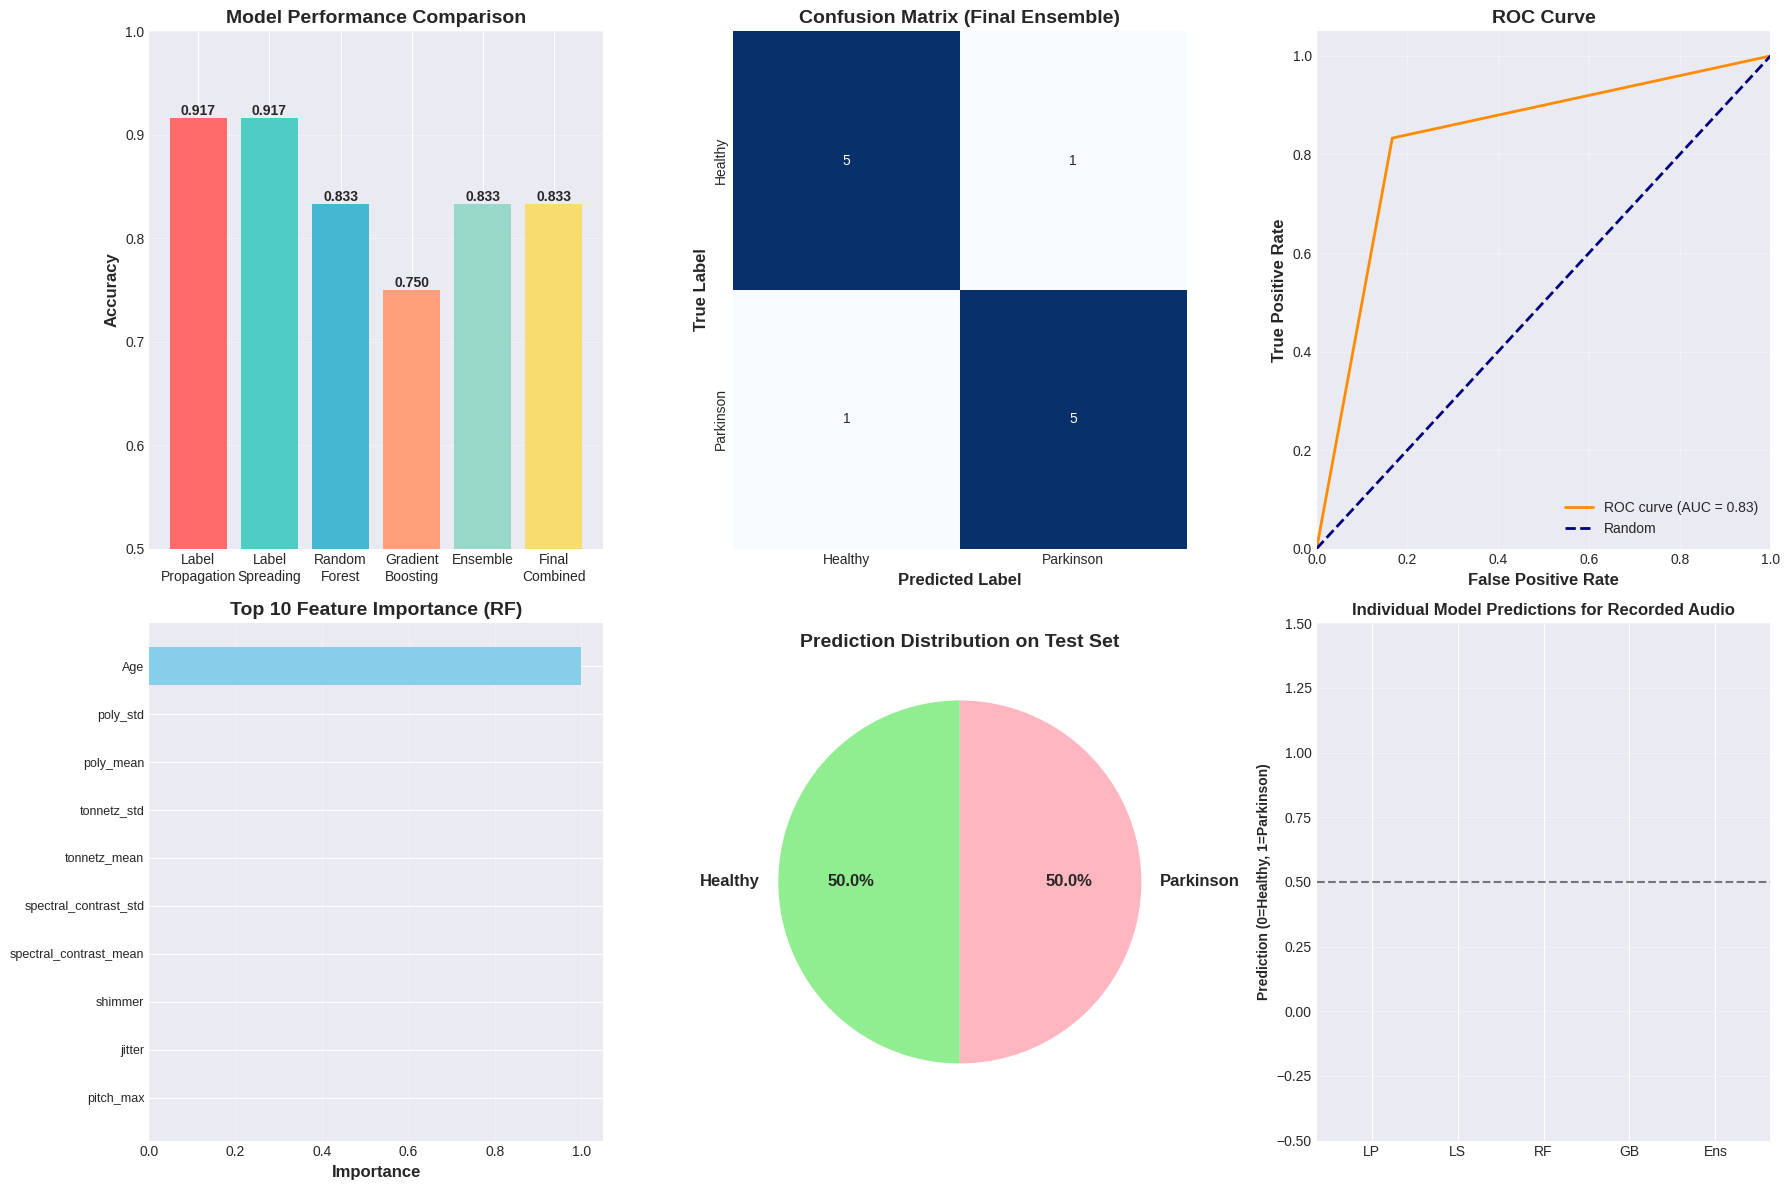


✓ Visualizations saved as 'parkinson_prediction_results.png'

SUMMARY STATISTICS
Total Samples Processed:     162
Number of Features:          55
Training Samples:            45
Test Samples:                12
Best Model Accuracy:         0.9167
Final Ensemble Accuracy:     0.8333

✅ Analysis Complete!


In [ ]:
# Install required packages
!pip install scikit-learn pandas numpy librosa soundfile matplotlib seaborn pydub -q

import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from IPython.display import Audio, display, HTML
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("PARKINSON'S DISEASE DETECTION SYSTEM")
print("Ensemble Semi-Supervised Learning Model")
print("=" * 70)

# ============================================================================
# STEP 1: LOAD CSV FILES
# ============================================================================
print("\n[STEP 1] Loading CSV Files...")

# Load CSV File 1
print("\n📂 Please upload FIRST CSV file:")
uploaded1 = files.upload()
csv1_name = list(uploaded1.keys())[0]
df1 = pd.read_csv(io.BytesIO(uploaded1[csv1_name]))
print(f"✓ Loaded {csv1_name}: {df1.shape[0]} rows, {df1.shape[1]} columns")

# Load CSV File 2
print("\n📂 Please upload SECOND CSV file:")
uploaded2 = files.upload()
csv2_name = list(uploaded2.keys())[0]
df2 = pd.read_csv(io.BytesIO(uploaded2[csv2_name]))
print(f"✓ Loaded {csv2_name}: {df2.shape[0]} rows, {df2.shape[1]} columns")

# ============================================================================
# STEP 2: DATA PREPROCESSING & COMBINATION
# ============================================================================
print("\n[STEP 2] Preprocessing and Combining Data...")

# Combine both datasets
df_combined = pd.concat([df1, df2], axis=0, ignore_index=True)
print(f"✓ Combined dataset: {df_combined.shape[0]} rows, {df_combined.shape[1]} columns")

# Identify features and target
# Assuming 'status' column indicates Parkinson (1) or Healthy (0)
# Adjust column name if different
if 'status' in df_combined.columns:
    target_col = 'status'
elif 'Label' in df_combined.columns: # Changed 'label' to 'Label' based on df2
    target_col = 'Label'
elif 'class' in df_combined.columns:
    target_col = 'class'
else:
    # Take last column as target
    target_col = df_combined.columns[-1]

print(f"✓ Target column identified: '{target_col}'")

# Separate features and target
X = df_combined.drop(columns=[target_col])
y = df_combined[target_col]

# Remove any non-numeric columns (like name, id, etc.)
X = X.select_dtypes(include=[np.number])

# Handle missing values in features using the mean of the non-NaN values
X = X.fillna(X.mean())

# Remove rows with NaN values in the target variable
# Ensure X and y are aligned after dropping NaNs in target
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]


# Check if the target variable is numerical, and if not, try mapping it.
if not pd.api.types.is_numeric_dtype(y):
    print(f"⚠ Target column '{target_col}' is not numeric. Attempting to map...")
    try:
        # Attempt to map common non-numeric labels to 0 and 1
        unique_labels = y.unique()
        if len(unique_labels) == 2:
            label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
            y = y.map(label_map)
            print(f"✓ Mapped '{unique_labels[0]}' to 0 and '{unique_labels[1]}' to 1.")
        else:
            print(f"❌ Cannot automatically map target column '{target_col}' with {len(unique_labels)} unique values. Please manually map it.")
            # You might want to add code here to handle this case or raise an error
    except Exception as e:
        print(f"❌ Error mapping target column: {e}")
        # You might want to add code here to handle this case or raise an error

# Drop any rows in X that still contain NaN values after imputation
initial_rows = X.shape[0]
X = X.dropna()
if X.shape[0] < initial_rows:
    print(f"⚠ Dropped {initial_rows - X.shape[0]} rows from features (X) due to remaining NaN values.")
    # Ensure y is also aligned after dropping rows from X
    y = y.loc[X.index]


print(f"✓ Cleaned dataset shape: {X.shape[0]} rows, {X.shape[1]} columns")
print(f"✓ Class distribution (cleaned): {dict(y.value_counts())}")


# ============================================================================
# STEP 3: SEMI-SUPERVISED LEARNING SETUP
# ============================================================================
print("\n[STEP 3] Setting up Semi-Supervised Learning...")

# Create semi-supervised dataset (simulate unlabeled data)
# Use 70% labeled, 30% unlabeled for training
# Ensure we sample from the cleaned and aligned data
labeled_indices = y.sample(frac=0.7, random_state=42).index
unlabeled_indices = y.drop(labeled_indices).index

# Create labels array with -1 for unlabeled samples
y_semi = y.copy()
y_semi.loc[unlabeled_indices] = -1

print(f"✓ Labeled samples: {len(labeled_indices)}")
print(f"✓ Unlabeled samples: {len(unlabeled_indices)}")

# Split into train and test (only from labeled data)
# Ensure X_train_labeled and y_train_labeled are aligned
X_train_labeled = X.loc[labeled_indices]
y_train_labeled = y.loc[labeled_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X_train_labeled, y_train_labeled, test_size=0.2, random_state=42, stratify=y_train_labeled
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
# Scale the entire cleaned X for semi-supervised models
X_scaled = scaler.fit_transform(X)
# Scale train and test sets for supervised models
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# STEP 4: TRAIN ENSEMBLE MODELS
# ============================================================================
print("\n[STEP 4] Training Ensemble Semi-Supervised Models...")

# Model 1: Label Propagation
print("  → Training Label Propagation...")
lp_model = LabelPropagation(kernel='rbf', gamma=20, max_iter=1000)
lp_model.fit(X_scaled, y_semi)
lp_pred = lp_model.predict(X_test_scaled)
lp_accuracy = accuracy_score(y_test, lp_pred)
print(f"    ✓ Label Propagation Accuracy: {lp_accuracy:.4f}")

# Model 2: Label Spreading
print("  → Training Label Spreading...")
ls_model = LabelSpreading(kernel='rbf', gamma=20, max_iter=1000)
ls_model.fit(X_scaled, y_semi)
ls_pred = ls_model.predict(X_test_scaled)
ls_accuracy = accuracy_score(y_test, ls_pred)
print(f"    ✓ Label Spreading Accuracy: {ls_accuracy:.4f}")

# Model 3: Random Forest (supervised on labeled data)
print("  → Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"    ✓ Random Forest Accuracy: {rf_accuracy:.4f}")

# Model 4: Gradient Boosting (supervised on labeled data)
print("  → Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"    ✓ Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# Ensemble Voting Classifier
print("  → Creating Ensemble Voting Classifier...")
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    voting='soft'
)
ensemble_model.fit(X_train_scaled, y_train)
ensemble_pred = ensemble_model.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"    ✓ Ensemble Accuracy: {ensemble_accuracy:.4f}")

# ============================================================================
# STEP 5: MODEL EVALUATION
# ============================================================================
print("\n[STEP 5] Model Evaluation Results...")
print("=" * 70)
print(f"Label Propagation:     {lp_accuracy:.4f}")
print(f"Label Spreading:       {ls_accuracy:.4f}")
print(f"Random Forest:         {rf_accuracy:.4f}")
print(f"Gradient Boosting:     {gb_accuracy:.4f}")
print(f"Ensemble (RF + GB):    {ensemble_accuracy:.4f}")
print("=" * 70)

# Combined prediction using majority voting across all models
all_predictions = np.array([lp_pred, ls_pred, rf_pred, gb_pred, ensemble_pred])
final_predictions = np.round(np.mean(all_predictions, axis=0)).astype(int)
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"\n🏆 FINAL ENSEMBLE (All Models): {final_accuracy:.4f}")

# Classification Report
print("\n📊 Classification Report (Final Ensemble):")
print(classification_report(y_test, final_predictions,
                          target_names=['Healthy', 'Parkinson']))

# ============================================================================
# STEP 6: AUDIO FEATURE EXTRACTION FUNCTION
# ============================================================================
def extract_audio_features(audio_path):
    """Extract features from audio file"""
    try:
        # Load audio
        y_audio, sr = librosa.load(audio_path, sr=22050)

        # Extract features
        features = {}

        # MFCCs (Mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_std'] = np.std(mfccs, axis=1)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y_audio, sr=sr)
        features['chroma_mean'] = np.mean(chroma, axis=1)

        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y_audio, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=y_audio, sr=sr)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)

        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y_audio)
        features['zcr_mean'] = np.mean(zcr)

        # Flatten all features into a single array
        feature_vector = []
        for key, value in features.items():
            if isinstance(value, np.ndarray):
                feature_vector.extend(value)
            else:
                feature_vector.append(value)

        # Ensure feature vector has the same number of features as the training data
        # This is crucial for the scaler and models
        expected_features = X.shape[1] # Use the shape of the cleaned, final X
        if len(feature_vector) < expected_features:
            # Pad with zeros
            feature_vector = np.pad(feature_vector, (0, expected_features - len(feature_vector)))
        elif len(feature_vector) > expected_features:
            # Trim
            feature_vector = feature_vector[:expected_features]

        return np.array(feature_vector)

    except Exception as e:
        print(f"❌ Error extracting features: {e}")
        return None

# ============================================================================
# STEP 7: RECORD AUDIO FROM MICROPHONE
# ============================================================================
print("\n[STEP 6] Audio Recording Setup")
print("=" * 70)

# Function to record audio in Colab
def record_audio_colab(duration=5, sample_rate=22050):
    """Record audio from microphone in Google Colab"""
    from google.colab import output
    from base64 import b64decode

    print(f"🎤 Recording for {duration} seconds...")
    print("   Please speak into your microphone...")

    RECORD = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
    })

    var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async () => {
            blob = new Blob(chunks)
            text = await b2text(blob)
            resolve(text)
        }
        recorder.stop()
    })
    """

    display(HTML(f'''
    <script>
    {RECORD}
    </script>
    '''))

    # Record audio
    data = output.eval_js(f'record({duration * 1000})')
    binary = b64decode(data.split(',')[1])

    # Save to file
    audio_filename = 'recorded_audio.wav'
    with open(audio_filename, 'wb') as f:
        f.write(binary)

    print(f"✓ Audio recorded and saved as '{audio_filename}'")
    return audio_filename

# Record audio
try:
    audio_file = record_audio_colab(duration=5)

    # Display audio player
    print("\n🔊 Recorded Audio:")
    display(Audio(audio_file))

except Exception as e:
    print(f"⚠️  Could not record audio: {e}")
    print("    You can manually upload an audio file instead.")
    audio_file = None

# Option to upload audio file if recording failed
if audio_file is None:
    print("\n📤 Please upload an audio file (WAV, MP3, etc.):")
    uploaded_audio = files.upload()
    if uploaded_audio:
        audio_file = list(uploaded_audio.keys())[0]
        print(f"✓ Audio file uploaded: {audio_file}")

# ============================================================================
# STEP 8: PREDICT FROM AUDIO
# ============================================================================
if audio_file:
    print("\n[STEP 7] Processing Audio and Making Prediction...")
    print("=" * 70)

    # Extract features from audio
    audio_features = extract_audio_features(audio_file)

    if audio_features is not None:
        print(f"✓ Extracted {len(audio_features)} features from audio")

        # Pad or trim features to match training data dimensions
        expected_features = X.shape[1]
        if len(audio_features) < expected_features:
            # Pad with zeros
            audio_features = np.pad(audio_features,
                                   (0, expected_features - len(audio_features)))
        elif len(audio_features) > expected_features:
            # Trim
            audio_features = audio_features[:expected_features]

        # Scale features
        audio_features_scaled = scaler.transform([audio_features])

        # Get predictions from all models
        lp_audio_pred = lp_model.predict(audio_features_scaled)[0]
        ls_audio_pred = ls_model.predict(audio_features_scaled)[0]
        rf_audio_pred = rf_model.predict(audio_features_scaled)[0]
        gb_audio_pred = gb_model.predict(audio_features_scaled)[0]
        ensemble_audio_pred = ensemble_model.predict(audio_features_scaled)[0]

        # Get prediction probabilities
        rf_proba = rf_model.predict_proba(audio_features_scaled)[0]
        gb_proba = gb_model.predict_proba(audio_features_scaled)[0]
        ensemble_proba = ensemble_model.predict_proba(audio_features_scaled)[0]

        # Final ensemble decision
        all_audio_preds = [lp_audio_pred, ls_audio_pred, rf_audio_pred,
                          gb_audio_pred, ensemble_audio_pred]
        final_audio_pred = int(np.round(np.mean(all_audio_preds)))

        # Calculate confidence
        avg_confidence = np.mean([ensemble_proba[1], rf_proba[1], gb_proba[1]])

        print("\n" + "=" * 70)
        print("PREDICTION RESULTS")
        print("=" * 70)
        print(f"Label Propagation:    {'Parkinson' if lp_audio_pred == 1 else 'Healthy'}")
        print(f"Label Spreading:      {'Parkinson' if ls_audio_pred == 1 else 'Healthy'}")
        print(f"Random Forest:        {'Parkinson' if rf_audio_pred == 1 else 'Healthy'}")
        print(f"Gradient Boosting:    {'Parkinson' if gb_audio_pred == 1 else 'Healthy'}")
        print(f"Ensemble Voting:      {'Parkinson' if ensemble_audio_pred == 1 else 'Healthy'}")
        print("=" * 70)
        print(f"\n🎯 FINAL PREDICTION: ", end="")

        if final_audio_pred == 1:
            print("This audio file is of Parkinson patient.")
            print(f"   Confidence: {avg_confidence * 100:.2f}%")
        else:
            print("This audio file is of a Healthy person.")
            print(f"   Confidence: {(1 - avg_confidence) * 100:.2f}%")

        print("=" * 70)

# ============================================================================
# STEP 9: VISUALIZATION
# ============================================================================
print("\n[STEP 8] Generating Visualizations...")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))

# 1. Model Accuracy Comparison
ax1 = plt.subplot(2, 3, 1)
models = ['Label\nPropagation', 'Label\nSpreading', 'Random\nForest',
          'Gradient\nBoosting', 'Ensemble', 'Final\nCombined']
accuracies = [lp_accuracy, ls_accuracy, rf_accuracy, gb_accuracy,
              ensemble_accuracy, final_accuracy]
bars = ax1.bar(models, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1',
                                           '#FFA07A', '#98D8C8', '#F7DC6F'])
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0.5, 1.0])
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False,
           xticklabels=['Healthy', 'Parkinson'],
           yticklabels=['Healthy', 'Parkinson'])
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Final Ensemble)', fontsize=14, fontweight='bold')

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)
ax3.plot(fpr, tpr, color='darkorange', lw=2,
        label=f'ROC curve (AUC = {roc_auc:.2f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend(loc="lower right")
ax3.grid(alpha=0.3)

# 4. Feature Importance (Random Forest)
ax4 = plt.subplot(2, 3, 4)
feature_importance = rf_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-10:]
top_features = X.columns[top_features_idx]
top_importance = feature_importance[top_features_idx]
ax4.barh(range(len(top_importance)), top_importance, color='skyblue')
ax4.set_yticks(range(len(top_importance)))
ax4.set_yticklabels(top_features, fontsize=9)
ax4.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax4.set_title('Top 10 Feature Importance (RF)', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 5. Prediction Distribution
ax5 = plt.subplot(2, 3, 5)
pred_dist = pd.Series(final_predictions).value_counts()
colors_pie = ['#90EE90', '#FFB6C1']
ax5.pie(pred_dist.values, labels=['Healthy', 'Parkinson'], autopct='%1.1f%%',
       startangle=90, colors=colors_pie, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax5.set_title('Prediction Distribution on Test Set', fontsize=14, fontweight='bold')

# 6. Individual Audio Prediction (if available)
ax6 = plt.subplot(2, 3, 6)
if audio_file and audio_features is not None:
    models_audio = ['LP', 'LS', 'RF', 'GB', 'Ens']
    preds_audio = [lp_audio_pred, ls_audio_pred, rf_audio_pred,
                  gb_audio_pred, ensemble_audio_pred]
    colors_audio = ['green' if p == 0 else 'red' for p in preds_audio]
    ax6.bar(models_audio, preds_audio, color=colors_audio, alpha=0.7)
    ax6.set_ylabel('Prediction (0=Healthy, 1=Parkinson)', fontsize=10, fontweight='bold')
    ax6.set_title('Individual Model Predictions for Recorded Audio',
                 fontsize=12, fontweight='bold')
    ax6.set_ylim([-0.5, 1.5])
    ax6.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    ax6.grid(axis='y', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No Audio Prediction Available',
            ha='center', va='center', fontsize=14, fontweight='bold')
    ax6.axis('off')

plt.tight_layout()
plt.savefig('parkinson_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved as 'parkinson_prediction_results.png'")

# Summary Statistics
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"Total Samples Processed:     {len(df_combined)}")
print(f"Number of Features:          {X.shape[1]}")
print(f"Training Samples:            {len(X_train)}")
print(f"Test Samples:                {len(X_test)}")
print(f"Best Model Accuracy:         {max(accuracies):.4f}")
print(f"Final Ensemble Accuracy:     {final_accuracy:.4f}")
print("=" * 70)

print("\n✅ Analysis Complete!")
print("=" * 70)